In [13]:
from glob import glob
import re
import pandas as pd

test_train_splits = [{"train": 0, "test": 0} for _ in range(5)]

for file in glob("../data/test_train_split/*.feather"):
    file_name = re.split("\\\\|/", file)[-1]
    test_train, split = file_name.split(".")[0].split("_")

    test_train_splits[int(split)][test_train] = pd.read_feather(file)

# FIXME: For the sake of this example, we feature engineer a trend (This should really be done in test_train)
MIN_DATE = test_train_splits[0]["train"]["Date"].min()
MAX_DATE = test_train_splits[-1]["train"]["Date"].max()
for i in range(len(test_train_splits)):
    test_train_splits[i]["train"]["trend"] = (test_train_splits[i]["train"]["Date"] - MIN_DATE).dt.days / (MAX_DATE - MIN_DATE).days
    test_train_splits[i]["test"]["trend"] = (test_train_splits[i]["test"]["Date"] - MIN_DATE).dt.days / (MAX_DATE - MIN_DATE).days

test_train_splits[-1]["train"].head()

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price,trend
0,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.900969,-0.5,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.0,44.97,0.000000
1,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.222521,-0.5,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.0,42.66,0.001453
2,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,0.623490,-0.5,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.0,41.20,0.002907
3,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,1.000000,-0.5,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.0,42.83,0.004360
4,2011-11-29,9.274873,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.623490,-0.5,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.0,46.88,0.005814


In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from copy import deepcopy

SCALER_VARIABLES = ["(-1)volume weighted price", "cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure", "snow_depth", "days_elapsed", "weekday sin", "weekday cos", "month sin", "month cos", "Time of Year sin", "Time of Year cos", "trend"]
DROP_VARIABLES = ["year", "Date"]
OUTPUT_VARIABLE = "avgKWH"

def do_transform(test_train_split, columns):
    train_df = test_train_split["train"].copy()
    train_df = train_df.drop(DROP_VARIABLES, axis=1)
    test_df = test_train_split["test"].copy()
    test_df = test_df.drop(DROP_VARIABLES, axis=1)

    scaler_encoders = []
    for scaler in SCALER_VARIABLES:
        encoder = StandardScaler()
        encoder.fit(train_df[scaler].values[:,np.newaxis])
        train_df[scaler] = encoder.transform(train_df[scaler].values[:,np.newaxis])
        test_df[scaler] = encoder.transform(test_df[scaler].values[:,np.newaxis])
        scaler_encoders.append(encoder)

    output_encoder = StandardScaler()
    output_encoder.fit(train_df[OUTPUT_VARIABLE].values[:, np.newaxis])
    train_df[OUTPUT_VARIABLE] = output_encoder.transform(train_df[OUTPUT_VARIABLE].values[:,np.newaxis])
    test_df[OUTPUT_VARIABLE] = output_encoder.transform(test_df[OUTPUT_VARIABLE].values[:,np.newaxis])

    train_x_df = train_df.drop(OUTPUT_VARIABLE, axis=1)
    # Only keep the columns we want
    if columns is not None:
        train_x_df = train_x_df[columns]

    test_train_split["train_x"] = train_x_df.to_numpy()
    test_train_split["train_y"] = train_df[OUTPUT_VARIABLE].to_numpy()
    
    test_x_df = test_df.drop(OUTPUT_VARIABLE, axis=1)
    # Only keep the columns we want
    if columns is not None:
        test_x_df = test_x_df[columns]

    test_train_split["test_x"] = test_x_df.to_numpy()
    test_train_split["test_y"] = test_df[OUTPUT_VARIABLE].to_numpy()

    test_train_split["input_encoders"] = scaler_encoders
    test_train_split["output_encoder"] = output_encoder

    return test_train_split

def get_test_train_splits_transformed(original_test_train_splits, columns=None):
    original_test_train_splits = deepcopy(original_test_train_splits)
    for i in range(len(original_test_train_splits)):
        original_test_train_splits[i] = do_transform(original_test_train_splits[i], columns=columns)
        # print(f"Train {i} Shape: {original_test_train_splits[i]['train_x'].shape}")
        # print(f"Test  {i} Shape: {original_test_train_splits[i]['test_x'].shape}")

    return original_test_train_splits

transformed_test_train_splits = get_test_train_splits_transformed(test_train_splits)

In [17]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_cross_validation(model, test_train_splits):
    rmses = []
    mapes = []
    y_trues = []
    y_preds = []

    for i in range(len(test_train_splits)):
        test_train_split = test_train_splits[i]
        model.fit(test_train_split["train_x"], test_train_split["train_y"])
        y_pred = model.predict(test_train_split["test_x"])
        y_pred = test_train_split["output_encoder"].inverse_transform(y_pred[:,np.newaxis])[:,0]

        y_true = test_train_split["test"][OUTPUT_VARIABLE].values
        
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        rmses.append(rmse)
        mapes.append(mape)

        y_trues.append(y_true)
        y_preds.append(y_pred)

    return rmses, mapes, y_trues, y_preds


rmses, mapes, y_trues, y_preds = evaluate_cross_validation(Ridge(), transformed_test_train_splits)
print(f"Avg RMSE: {sum(rmses) / len(rmses):0.5f}")
print(f"Avg MAPE: {100 * sum(mapes) / len(mapes):0.2f}%")

Avg RMSE: 0.46039
Avg MAPE: 5.64%


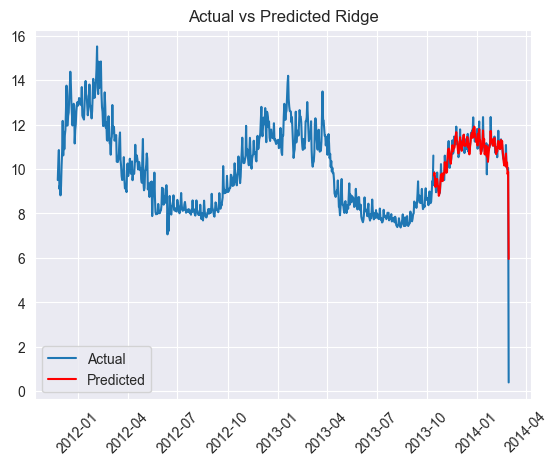

In [18]:
import matplotlib.pyplot as plt

def plot_best_models(model, test_train_splits, model_name):
    model.fit(test_train_splits[-1]["train_x"], test_train_splits[-1]["train_y"])

    y_pred = model.predict(test_train_splits[-1]["test_x"])
    y_pred = test_train_splits[-1]["output_encoder"].inverse_transform(y_pred[:,np.newaxis])

    # Plot last test_train_split
    plt.plot(test_train_splits[-1]["train"]["Date"].values, test_train_splits[-1]["train"]["avgKWH"].values) # Plot the train
    plt.plot(test_train_splits[-1]["test"]["Date"].values, y_trues[-1], c="tab:blue", label="Actual")
    plt.plot(test_train_splits[-1]["test"]["Date"].values, y_pred, c="#FF0000", label="Predicted")
    plt.legend(loc="lower left")
    plt.xticks(rotation=45)
    plt.title(f"Actual vs Predicted {model_name}")

    # TODO: add residual plots here as needed

plot_best_models(Ridge(), transformed_test_train_splits, model_name="Ridge")

# Base Model

RMSE: 0.46 MAPE: 0.06


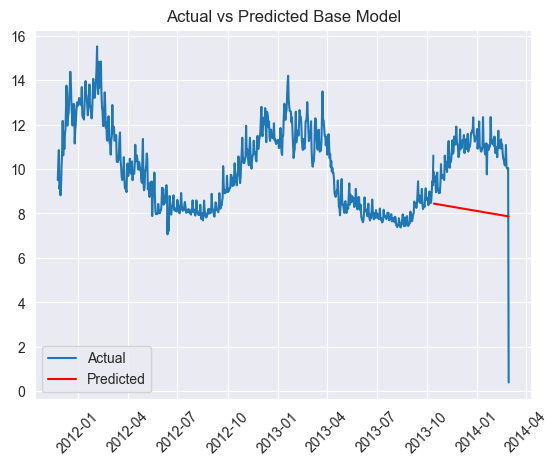

In [21]:
import math
import random
from random import choice

# Get test train split with only trend
baseline_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=["trend"])
# Train model
rmses, mapes, y_trues, y_preds = evaluate_cross_validation(Ridge(), transformed_test_train_splits)
# Plot results
plot_best_models(Ridge(), baseline_test_train_splits, "Base Model")
print(f"RMSE: {sum(rmses) / len(rmses):0.2f} MAPE: {sum(mapes) / len(mapes):0.2f}")

# Linear

In [ ]:
# Get test train split for all the data (Used for the remainder of the notebook)
all_data_test_train_splits = get_test_train_splits_transformed(test_train_splits, columns=None)

In [ ]:
import math
import random
from random import choice

RANDOM_SAMPLES = 30
tests = {} # (alpha) => (avg mape, avg, rmse)

ALPHAS = [10_000, 5_000, 1_000, 500.0, 100.0, 50.0, 10.0, 5.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

random.seed(42)
np.random.seed(42)
for alpha in ALPHAS:
    k = (alpha)
    if k in tests:
        continue

    mlp_model = Ridge(alpha)
    rmses, mapes, y_trues, y_preds = evaluate_cross_validation(mlp_model, all_data_test_train_splits)
    avg_mape = sum(mapes) / len(mapes)
    avg_rmse = sum(rmses) / len(rmses)
    tests[k] = (avg_mape, avg_rmse)
    
    print(f"(alpha={alpha}) => (MAPE={avg_mape}, RMSE={avg_rmse})")

In [ ]:
rows = [{'alpha': k, 'mape': v[0], 'rmse': v[1]} for k,v in tests.items()]
hp_df = pd.DataFrame(rows)
hp_df[hp_df["rmse"] == hp_df["rmse"].min()]

In [ ]:
plot_best_models(Ridge(100), all_data_test_train_splits, "Ridge")

# MLP

In [ ]:
def scaled_random_range(min=2, max=64):
    min_log = math.log(min, 2)
    max_log = math.log(max, 2)

    rand_log = min_log + (random.random() * (max_log - min_log))
    rand = math.pow(2, rand_log)
    return rand

RANDOM_SAMPLES = 30
tests = {} # (layer_1, layer_2, activation) => (avg mape, avg, rmse)

random.seed(42)
np.random.seed(42)
for i in range(RANDOM_SAMPLES):
    layer_1 = int(scaled_random_range(1, 128))
    layer_2 = int(scaled_random_range(1, 128))
    activation_func = choice(["relu", "tanh", "logistic"])

    k = (layer_1, layer_2, activation_func)
    if k in tests:
        continue

    mlp_model = MLPRegressor(hidden_layer_sizes=(layer_1, layer_2), activation=activation_func, early_stopping=True, max_iter=10_000)
    rmses, mapes, y_trues, y_preds = evaluate_cross_validation(mlp_model, all_data_test_train_splits)
    avg_mape = sum(mapes) / len(mapes)
    avg_rmse = sum(rmses) / len(rmses)
    tests[k] = (avg_mape, avg_rmse)
    
    print(f"Sample {i} (layer_1={layer_1}, layer_2={layer_2}, activation={activation_func}) => (MAPE={avg_mape}, RMSE={avg_rmse})")

In [ ]:
rows = [{'layer_1': k[0], 'layer_2': k[1], 'activation': k[2], 'mape': v[0], 'rmse': v[1]} for k,v in tests.items()]
hp_df = pd.DataFrame(rows)
hp_df[hp_df["rmse"] == hp_df["rmse"].min()]

In [ ]:
plot_best_models(MLPRegressor(hidden_layer_sizes=(15, 32), activation="logistic", early_stopping=True, max_iter=10_000), all_data_test_train_splits, "MLP")